# Preliminary agent based model (ABM)

The following script simulates an economy with 100 heterogeneous agents whose behavior the central planner adjusts its tax brackets to. Agents are allowed to relocate if their expected utility is higher abroad. The simulation converges at a tax schedual that maximises government revenue whilst minimizing the emigration of high-income earners. 

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import itertools

In [29]:
class TaxSimEnv(Env):
    def __init__(self, N=100):
        super().__init__()
        self.N = N
        self.e = np.random.uniform(0.8, 1.2, N)  # narrower income efficiency range
        self.phi = np.random.uniform(0.2, 0.4, N)  # smoother relocation sensitivity
        self.kappa = np.random.uniform(0.5, 0.9, N)  # increased relocation cost
        self.z_foreign = 0.8  # lower outside option to reduce excessive relocation
        self.lambda_ = 0.9  # slightly higher redistribution
        self.eta = 2.0
        self.psi = 0.8  # more elastic labor response
        self.A = 1.0
        self.b = [0.2, 0.4, 0.6, 0.8]
        self.tau_vals = [0.05, 0.1, 0.15, 0.2, 0.25]

        self.bracket_space = sorted(set(tuple(sorted(t)) for t in itertools.product(self.tau_vals, repeat=5)))
        self.tau_to_idx = {tuple(x): i for i, x in enumerate(self.bracket_space)}
        self.idx_to_tau = {i: x for i, x in enumerate(self.bracket_space)}

        self.action_space = Discrete(len(self.bracket_space))
        self.observation_space = Box(low=0, high=np.inf, shape=(4,), dtype=np.float32)
        self.reset()

    def encode_action(self, tau_tuple):
        clean = tuple(sorted(float(x) for x in np.array(tau_tuple).flatten()))
        return self.tau_to_idx[clean]

    def decode_action(self, index):
        return self.idx_to_tau[int(index)]

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.h = np.ones(self.N)
        self.relocated = np.zeros(self.N, dtype=bool)
        self.timestep = 0
        self.total_revenue = 0.0
        self.total_relocated = 0
        return self._get_obs(), {}

    def _get_obs(self):
        active = ~self.relocated
        z = self.e[active] * self._wage() * self.h[active]
        mu_z = np.mean(z) if len(z) > 0 else 0.0
        sigma_z = np.std(z) if len(z) > 0 else 0.0
        return np.array([mu_z, sigma_z, float(np.sum(self.relocated)), float(self.total_revenue)], dtype=np.float32)

    def _wage(self):
        L = np.sum(self.h[~self.relocated])
        return self.A * self.psi * L ** (self.psi - 1) if L > 0 else 0.0

    def step(self, action):
        tau = self.decode_action(action)
        w = self._wage()
        z = self.e * w * self.h
        z[self.relocated] = 0

        tau_z = np.piecewise(
            z,
            [z < self.b[0],
             (z >= self.b[0]) & (z < self.b[1]),
             (z >= self.b[1]) & (z < self.b[2]),
             (z >= self.b[2]) & (z < self.b[3]),
             z >= self.b[3]],
            tau
        )

        taxes = tau_z * z
        R_t = np.sum(taxes)
        x = self.lambda_ * R_t / self.N
        stay_payoff = (z - taxes) + x
        leave_payoff = self.z_foreign - self.kappa

        newly_relocated = (stay_payoff < leave_payoff) & (~self.relocated)
        self.relocated |= newly_relocated
        self.h[self.relocated] = 0

        self.total_revenue = R_t
        self.total_relocated = np.sum(self.relocated)
        self.timestep += 1
        terminated = self.timestep >= 50  # longer episode for stabilization
        reward = R_t - 0.05 * np.sum(newly_relocated)  # smaller penalty for better exploration

        return self._get_obs(), reward, terminated, False, {}

In [ ]:
class EvaluationCallback(BaseCallback):
    def __init__(self, eval_env, eval_freq=500, n_eval_episodes=5, verbose=1):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.logs = []

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            avg_reward, avg_gdp, avg_gini = 0, 0, 0
            for _ in range(self.n_eval_episodes):
                obs, _ = self.eval_env.reset()
                done = False
                total_reward = 0
                gdp, gini = [], []
                while not done:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, reward, done, _, _ = self.eval_env.step(action)
                    total_reward += reward

                    # GDP at step
                    e = self.eval_env.e[~self.eval_env.relocated]
                    h = self.eval_env.h[~self.eval_env.relocated]
                    w = self.eval_env._wage()
                    income = e * w * h
                    gdp.append(np.sum(income))

                    # Gini at step
                    sorted_income = np.sort(income)
                    cum_income = np.cumsum(sorted_income)
                    if len(cum_income) > 0:
                        gini_val = 1 - 2 * np.sum(cum_income) / (len(income) * cum_income[-1]) + 1 / len(income)
                        avg_gini += gini_val

                avg_reward += total_reward
                avg_gdp += np.mean(gdp)

            self.logs.append({
                'step': self.n_calls,
                'avg_reward': avg_reward / self.n_eval_episodes,
                'avg_gdp': avg_gdp / self.n_eval_episodes,
                'avg_gini': avg_gini / self.n_eval_episodes
            })
        return True


In [ ]:
train_env = TaxSimEnv()
eval_env = TaxSimEnv()
callback = EvaluationCallback(eval_env, eval_freq=1000, n_eval_episodes=3)

model = DQN("MlpPolicy", train_env, verbose=0)
model.learn(total_timesteps=10000, callback=callback)

# Save logs as DataFrame
import pandas as pd
logs_df = pd.DataFrame(callback.logs)


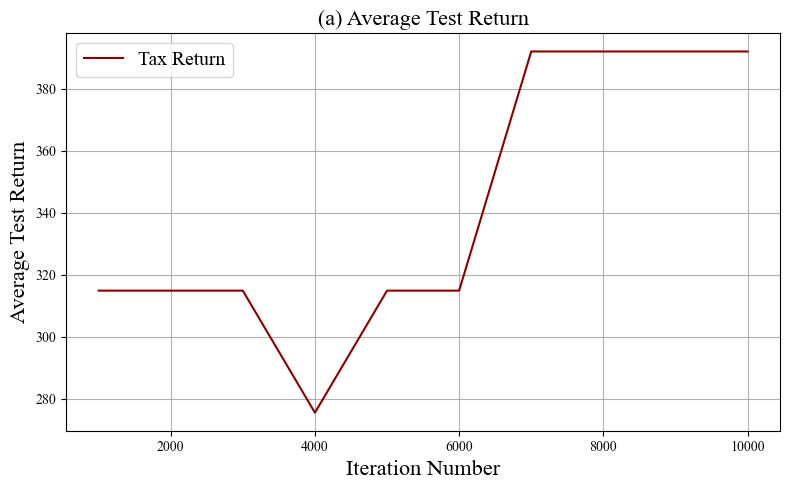

In [ ]:
plt.rcParams["font.family"] = "Times New Roman"

fig, ax = plt.subplots(figsize=(8, 5))  # Single plot

ax.plot(logs_df["step"], logs_df["avg_reward"], label="Tax Return", color='darkred')
ax.set_title("(a) Average Test Return", fontsize=16)
ax.set_xlabel("Iteration Number", fontsize=16)
ax.set_ylabel("Average Test Return", fontsize=16)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.grid(True)
ax.legend(fontsize=14)

plt.tight_layout()
plt.show()

In [78]:
final_action = model.predict(env.reset()[0])[0]
final_bracket = env.decode_action(final_action)
print("Final Tax Policy (Sorted Brackets):", final_bracket)
print("Number of Agents Relocated:", np.sum(env.relocated))

Final Tax Policy (Sorted Brackets): (0.05, 0.1, 0.1, 0.2, 0.25)
Number of Agents Relocated: 0


In [ ]:
# Helper: compute Gini coefficient
def gini_coefficient(x):
    x = np.sort(x)
    n = len(x)
    if n == 0:
        return 0.0
    cumx = np.cumsum(x)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

# Reset environment
obs, _ = env.reset()
cumulative_relocation = []

# Track income distribution and GDP at final timestep
final_incomes = None
final_gdp = 0.0

max_timesteps = 50  # length of episode

for t in range(max_timesteps):
    action, _ = model.predict(obs)
    obs, reward, done, truncated, info = env.step(action)
    
    relocated_now = np.sum(env.relocated)
    cumulative_relocation.append(relocated_now)
    
    if done:
        break

# Compute final income distribution and GDP
active = ~env.relocated
wage = env._wage()
final_incomes = env.e[active] * wage * env.h[active]
final_gdp = np.sum(final_incomes)
gini = gini_coefficient(final_incomes)

# Final results
final_policy = env.decode_action(action)
print("🧾 Final Tax Policy (Sorted Brackets):", final_policy)
print("🚶 Total Number of Relocated Agents:", cumulative_relocation[-1])
print(f"📈 Final GDP: {final_gdp:.2f}")
print(f"📊 Gini Coefficient: {gini:.4f}")

🧾 Final Tax Policy (Sorted Brackets): (0.05, 0.25, 0.3, 0.3, 0.3)
🚶 Total Number of Relocated Agents: 0
📈 Final GDP: 129.04
📊 Gini Coefficient: 0.1659


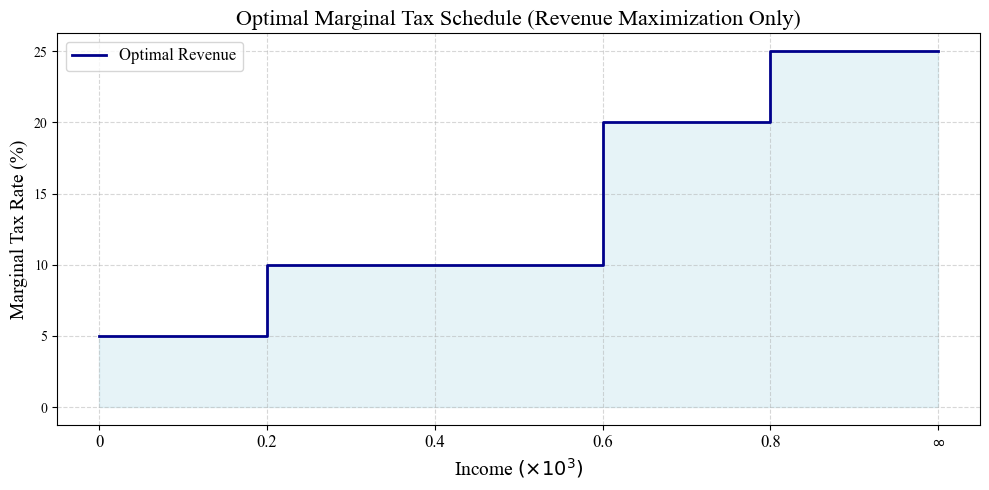

In [ ]:
# Use Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Define income brackets and corresponding labels
income_brackets = [0, 0.2, 0.4, 0.6, 0.8]
income_brackets_extended = income_brackets + [1.0]  # Final step
income_labels = ['0', '0.2', '0.4', '0.6', '0.8', r'$\infty$']

# Final learned tax rates (converted to %)
tax_rates_learned = [5, 10, 10, 20, 25]
tax_rates_extended = tax_rates_learned + [25]  # Extend last for horizontal line

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.step(income_brackets_extended, tax_rates_extended, where='post', color='darkblue', linewidth=2, label='Optimal Revenue')
ax.fill_between(income_brackets_extended, 0, tax_rates_extended, step='post', color='lightblue', alpha=0.3)

# Axis labels and styling
ax.set_xticks(income_brackets_extended)
ax.set_xticklabels(income_labels, fontsize=12)
ax.set_xlabel(r'Income $(\times 10^3)$', fontsize=14)
ax.set_ylabel('Marginal Tax Rate (%)', fontsize=14)
ax.set_title('Optimal Marginal Tax Schedule (Revenue Maximization Only)', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

----